In [1]:
import itertools

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, kpss
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings

warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('data.csv', delimiter=';')
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df.head(10)

,open,close,high,low,volume,company
time,,,,,,
2006-07-19 00:00:00+00:00,203.25,203.50,204.30,200.20,61148110,ROSN
2006-07-20 00:00:00+00:00,204.35,203.75,204.45,203.15,11412880,ROSN
2006-07-21 00:00:00+00:00,203.50,201.85,203.65,200.30,18641060,ROSN
2006-07-24 00:00:00+00:00,202.40,202.00,202.40,201.30,7941520,ROSN
2006-07-25 00:00:00+00:00,203.30,202.60,203.75,202.00,16748340,ROSN
2006-07-26 00:00:00+00:00,202.10,203.00,203.25,202.10,10092000,ROSN
2006-07-27 00:00:00+00:00,203.85,203.50,203.85,203.35,21987360,ROSN
2006-07-28 00:00:00+00:00,203.25,203.05,203.35,202.80,5233100,ROSN
2006-07-31 00:00:00+00:00,203.10,202.60,203.10,202.60,4440,ROSN


In [3]:
tickers = ['ROSN', 'GAZP', 'LKOH', 'NVTK', 'SNGS', 'TATN']

ROSN = df[df['company'] == 'ROSN'].drop(columns=['company'])
GAZP = df[df['company'] == 'GAZP'].drop(columns=['company'])
LKOH = df[df['company'] == 'LKOH'].drop(columns=['company'])
NVTK = df[df['company'] == 'NVTK'].drop(columns=['company'])
SNGS = df[df['company'] == 'SNGS'].drop(columns=['company'])
TATN = df[df['company'] == 'TATN'].drop(columns=['company'])

dataframes = {ticker: eval(ticker) for ticker in tickers}
ma_day = [50, 100, 300]

ma_columns = [f"MA_{ma}d" for ma in ma_day]

for ticker, df in dataframes.items():
    dataframes[ticker] = df.drop(columns=ma_columns, errors='ignore')

ROSN, GAZP, LKOH, NVTK, SNGS, TATN = [dataframes[ticker] for ticker in tickers]

#### Пример обучения модели на тикере ROSN ####

In [14]:
# Функция для проведения теста ADF
def adf_test(series):
    print(f'Результаты ADF теста для Close Prices')
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['ADF Статистика', 'p-value', '# лагов', '# наблюдений']
    for value, label in zip(result[:4], labels):
        print(f'{label}: {value}')
    if result[1] <= 0.05:
        print("Ряд стационарен по ADF тесту\n")
    else:
        print("Ряд не стационарен по ADF тесту\n")

# Функция для проведения теста KPSS
def kpss_test(series):
    print(f'Результаты KPSS теста для Differenced Close Prices')
    stat, p_value, n_lags, crit = kpss(series.dropna(), regression='c', nlags="auto")
    print(f'KPSS Статистика: {stat}')
    print(f'p-value: {p_value}')
    if p_value <= 0.05:
        print("Ряд не стационарен по KPSS тесту\n")
    else:
        print("Ряд стационарен по KPSS тесту\n")

adf_test(ROSN['close'])
kpss_test(ROSN['close'])

# применяем дифференцирование
ROSN['close_diff'] = ROSN['close'].diff()
adf_test(ROSN['close_diff'])
kpss_test(ROSN['close_diff'])

Результаты ADF теста для Close Prices
ADF Статистика: -1.6607244809187618
p-value: 0.45145346982046064
# лагов: 32
# наблюдений: 4666
Ряд не стационарен по ADF тесту

Результаты KPSS теста для Differenced Close Prices
KPSS Статистика: 8.725724774602364
p-value: 0.01
Ряд не стационарен по KPSS тесту

Результаты ADF теста для Close Prices
ADF Статистика: -12.374545434085734
p-value: 5.1908575433876524e-23
# лагов: 31
# наблюдений: 4666
Ряд стационарен по ADF тесту

Результаты KPSS теста для Differenced Close Prices
KPSS Статистика: 0.023819659851437018
p-value: 0.1
Ряд стационарен по KPSS тесту



In [5]:
# Добавляем скользящее среднее
ROSN['rolling_mean'] = ROSN['close'].rolling(window=5).mean()

# Создаем лаговые признаки для дифференцированного ряда
ROSN['lag1'] = ROSN['close_diff'].shift(1)
ROSN['lag2'] = ROSN['close_diff'].shift(2)

data = ROSN.dropna()

# Определяем размер тестовой выборки – 252 торговых дня (1 год)
test_size = 252
train = data.iloc[:-test_size]
test = data.iloc[-test_size:]

print(f'Обуч. выборка: {len(train)}')
print(f'Тест. выборки: {len(test)}')


Обуч. выборка: 4443
Тест. выборки: 252


In [6]:
exog_features = ['rolling_mean', 'lag1', 'lag2']
exog_train = train[exog_features]
exog_test = test[exog_features]

aic_results = []
p = q = range(0, 3)
d = 1  # фиксированное, так как мы уже дифференцировали

for i, j in itertools.product(p, q):
    try:
        model = SARIMAX(train['close'], order=(i, d, j), exog=exog_train,
                        enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit(disp=False)
        aic_results.append(((i, d, j), model_fit.aic))
        print(f'ARIMAX{(i, d, j)} AIC: {model_fit.aic}')
    except Exception as e:
        print(f'ARIMAX{(i, d, j)} не обучилась: {e}')

# Выбираем лучшую модель по минимальному AIC
best_params, best_aic = min(aic_results, key=lambda x: x[1])
print(f'\nЛучшие параметры: ARIMAX{best_params} с AIC: {best_aic}')


ARIMAX(0, 1, 0) AIC: 28432.019405723877
ARIMAX(0, 1, 1) AIC: 27706.490154125502
ARIMAX(0, 1, 2) AIC: 27617.49790230043
ARIMAX(1, 1, 0) AIC: 28321.59607298935
ARIMAX(1, 1, 1) AIC: 27601.97623983486
ARIMAX(1, 1, 2) AIC: 27536.180361186605
ARIMAX(2, 1, 0) AIC: 28025.103453004922
ARIMAX(2, 1, 1) AIC: 27497.258313395847
ARIMAX(2, 1, 2) AIC: 27515.610292057485

Лучшие параметры: ARIMAX(2, 1, 1) с AIC: 27497.258313395847


                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 4443
Model:               SARIMAX(2, 1, 1)   Log Likelihood              -13741.629
Date:                Tue, 18 Mar 2025   AIC                          27497.258
Time:                        01:36:42   BIC                          27542.047
Sample:                             0   HQIC                         27513.051
                               - 4443                                         
Covariance Type:                  opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
rolling_mean     1.0019      0.002    611.990      0.000       0.999       1.005
lag1            -0.2046      0.010    -19.950      0.000      -0.225      -0.184
lag2            -0.1002      0.009    -11.03

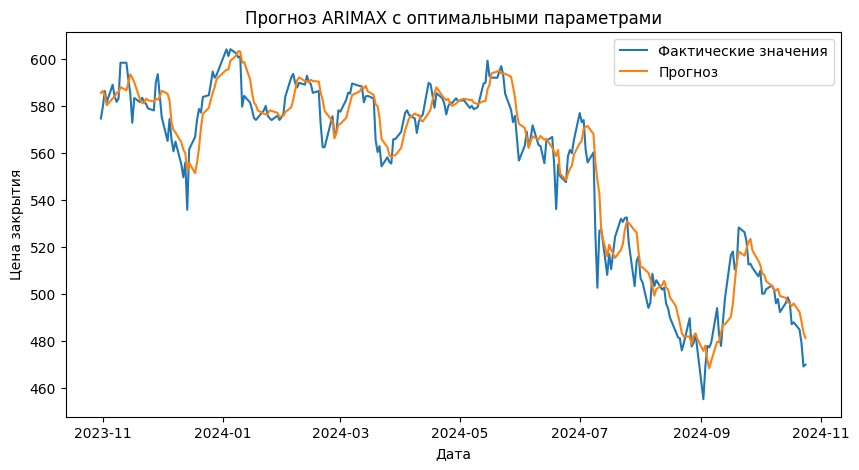

In [7]:
model = SARIMAX(train['close'], order=best_params, exog=exog_train,
                enforce_stationarity=False, enforce_invertibility=False)
model_fit = model.fit(disp=False)
print(model_fit.summary())

forecast = model_fit.forecast(steps=len(test), exog=exog_test)

# метрики
rmse = np.sqrt(mean_squared_error(test['close'], forecast))
mae = mean_absolute_error(test['close'], forecast)
print(f'\nRMSE: {rmse}')
print(f'MAE: {mae}')

plt.figure(figsize=(10,5))
plt.plot(test.index, test['close'], label='Фактические значения')
plt.plot(test.index, forecast, label='Прогноз')
plt.xlabel('Дата')
plt.ylabel('Цена закрытия')
plt.title('Прогноз ARIMAX с оптимальными параметрами')
plt.legend()
plt.show()

## CatBoost ##

In [10]:
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV

# Извлечение временных признаков
ROSN['day'] = ROSN.index.day
ROSN['month'] = ROSN.index.month
ROSN['week'] = ROSN.index.isocalendar().week.astype(int)
ROSN['year'] = ROSN.index.year
ROSN['day_of_week'] = ROSN.index.dayofweek

data.head()

,open,close,high,low,volume,close_diff,rolling_mean,lag1,lag2
time,,,,,,,,,
2006-07-25 00:00:00+00:00,203.30,202.60,203.75,202.00,16748340,0.60,202.74,0.15,-1.90
2006-07-26 00:00:00+00:00,202.10,203.00,203.25,202.10,10092000,0.40,202.64,0.60,0.15
2006-07-27 00:00:00+00:00,203.85,203.50,203.85,203.35,21987360,0.50,202.59,0.40,0.60
2006-07-28 00:00:00+00:00,203.25,203.05,203.35,202.80,5233100,-0.45,202.83,0.50,0.40
2006-07-31 00:00:00+00:00,203.10,202.60,203.10,202.60,4440,-0.45,202.95,-0.45,0.50


In [9]:
# Разбиение на обучающую и тестовую выборки
test_size = 252
train = ROSN.iloc[:-test_size]
test = ROSN.iloc[-test_size:]

In [11]:
features = ['open', 'high', 'low', 'volume', 'day', 'month', 'week', 'year', 'day_of_week']
target = 'close'

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]


model = CatBoostRegressor(random_seed=42, silent=True)

# гиперпараметры для перебора
param_grid = {
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [100, 300, 500],
    'l2_leaf_reg': [1, 3, 5]
}

# GridSearchCV с кросс-валидацией
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3,
                           scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Вывод лучших гиперпараметров и результата
print("Лучшие параметры:", grid_search.best_params_)
print("Лучший результат (MSE):", -grid_search.best_score_)



Fitting 3 folds for each of 81 candidates, totalling 243 fits
Лучшие параметры: {'depth': 4, 'iterations': 500, 'l2_leaf_reg': 1, 'learning_rate': 0.1}
Лучший результат (MSE): 2500.2245525124254


In [12]:
best_model = grid_search.best_estimator_

predictions = best_model.predict(X_test)

# метрики
rmse = np.sqrt(mean_squared_error(y_test, predictions))
mae = mean_absolute_error(y_test, predictions)
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')


RMSE: 6.1240040372535285
MAE: 4.8407429700163025


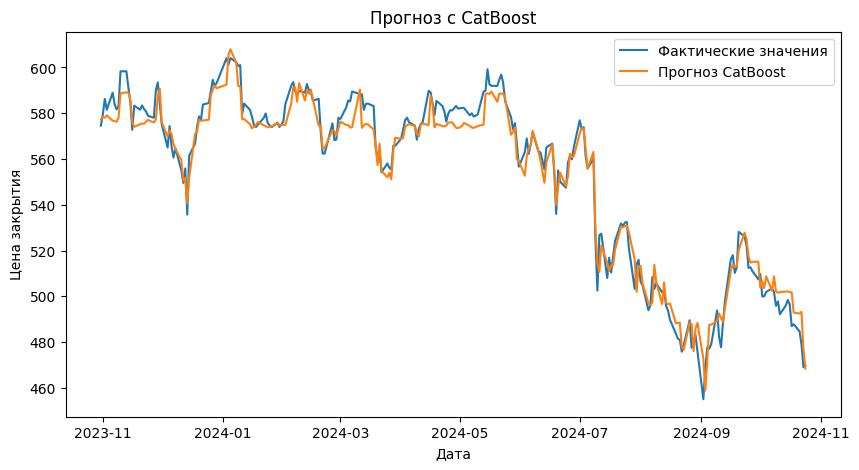

In [13]:
plt.figure(figsize=(10,5))
plt.plot(test.index, y_test, label='Фактические значения')
plt.plot(test.index, predictions, label='Прогноз CatBoost')
plt.xlabel('Дата')
plt.ylabel('Цена закрытия')
plt.title('Прогноз с CatBoost')
plt.legend()
plt.show()
